In [5]:
from func import *
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
raw_df = load_csvs_from_ftp_to_df(provided_local_dir="./")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68493 entries, 3 to 134260
Data columns (total 78 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuyerAgentAOR                 68482 non-null  object 
 1   ListAgentAOR                  68482 non-null  object 
 2   Flooring                      44600 non-null  object 
 3   ViewYN                        61985 non-null  object 
 4   WaterfrontYN                  27 non-null     object 
 5   BasementYN                    1687 non-null   object 
 6   PoolPrivateYN                 63200 non-null  object 
 7   OriginalListPrice             68352 non-null  float64
 8   ListingKey                    68493 non-null  int64  
 9   ListAgentEmail                68260 non-null  object 
 10  CloseDate                     68493 non-null  object 
 11  ClosePrice                    68493 non-null  float64
 12  ListAgentFirstName            68002 non-null  object 
 13  ListA

In [4]:
# simple pre-processed
processed_df = pre_process(raw_df, save=False)

In [5]:
print(processed_df.describe()["ClosePrice"])
close_price = processed_df["ClosePrice"]
log_close_price = np.log(close_price)
processed_df["logClosePrice"] = log_close_price
processed_df.info()

count    6.781700e+04
mean     1.190862e+06
min      1.900000e+05
25%      6.300000e+05
50%      8.900000e+05
75%      1.400000e+06
max      8.750000e+06
std      9.574866e+05
Name: ClosePrice, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 67817 entries, 3 to 134260
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   BuyerAgentAOR             67806 non-null  object        
 1   ListAgentAOR              67806 non-null  object        
 2   Flooring                  44217 non-null  object        
 3   ViewYN                    61318 non-null  object        
 4   PoolPrivateYN             62634 non-null  object        
 5   OriginalListPrice         67677 non-null  float64       
 6   CloseDate                 67817 non-null  datetime64[ns]
 7   ClosePrice                67817 non-null  float64       
 8   Latitude                  67813 non-null  float64       
 9  


# 1. ClosePrice


## 1.1 Distribution

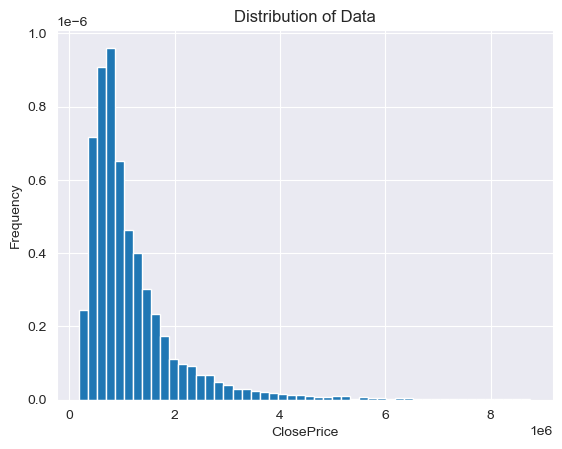

In [6]:
# Show distribution of data
plt.hist(close_price, bins=50, density=True)
plt.xlabel("ClosePrice")
plt.ylabel("Frequency")
plt.title("Distribution of Data")
plt.grid(True)

plt.show()

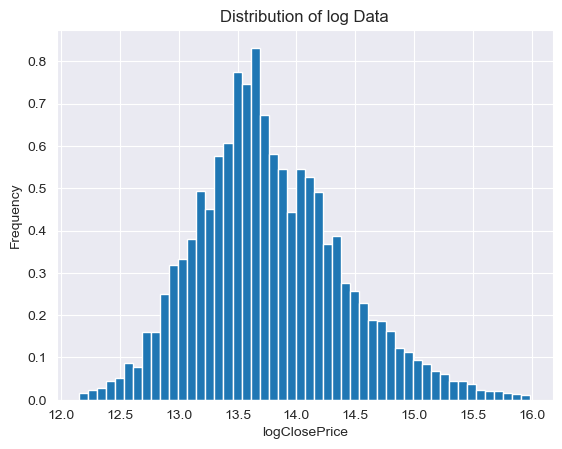

In [7]:
plt.hist(log_close_price, bins=50, density=True)
plt.xlabel("logClosePrice")
plt.ylabel("Frequency")
plt.title("Distribution of log Data")
plt.grid(True)

plt.show()


## 1.2 price by date

In [8]:
median_df = (
    processed_df.groupby("CloseDate", as_index=False)["logClosePrice"]
    .median()
)

avg_df = (
    processed_df.groupby("CloseDate", as_index=False)["logClosePrice"]
    .mean()
)

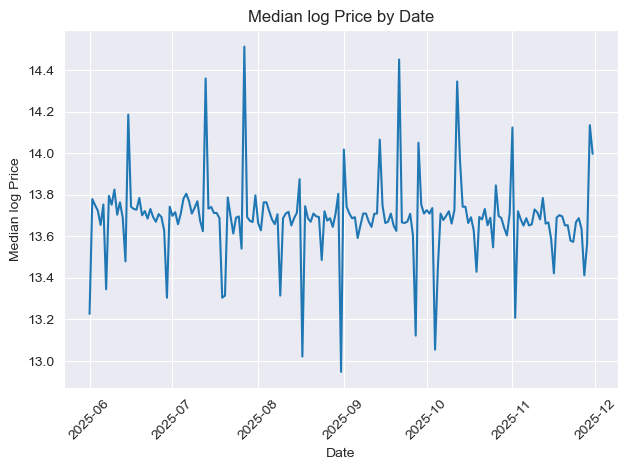

In [9]:
plt.figure()
plt.plot(median_df["CloseDate"], median_df["logClosePrice"])
plt.xlabel("Date")
plt.ylabel("Median log Price")
plt.title("Median log Price by Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

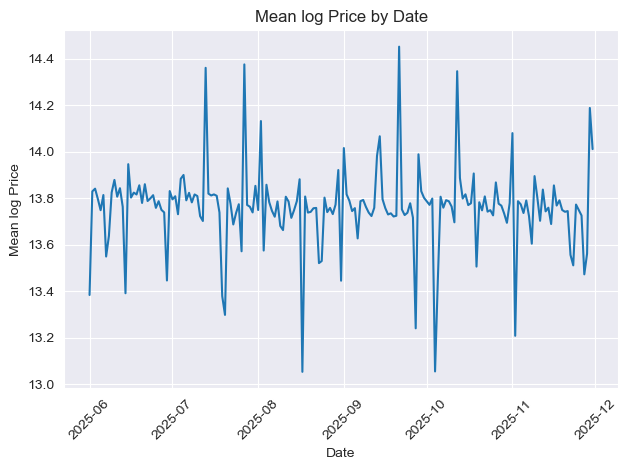

In [10]:
plt.figure()
plt.plot(avg_df["CloseDate"], avg_df["logClosePrice"])
plt.xlabel("Date")
plt.ylabel("Mean log Price")
plt.title("Mean log Price by Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

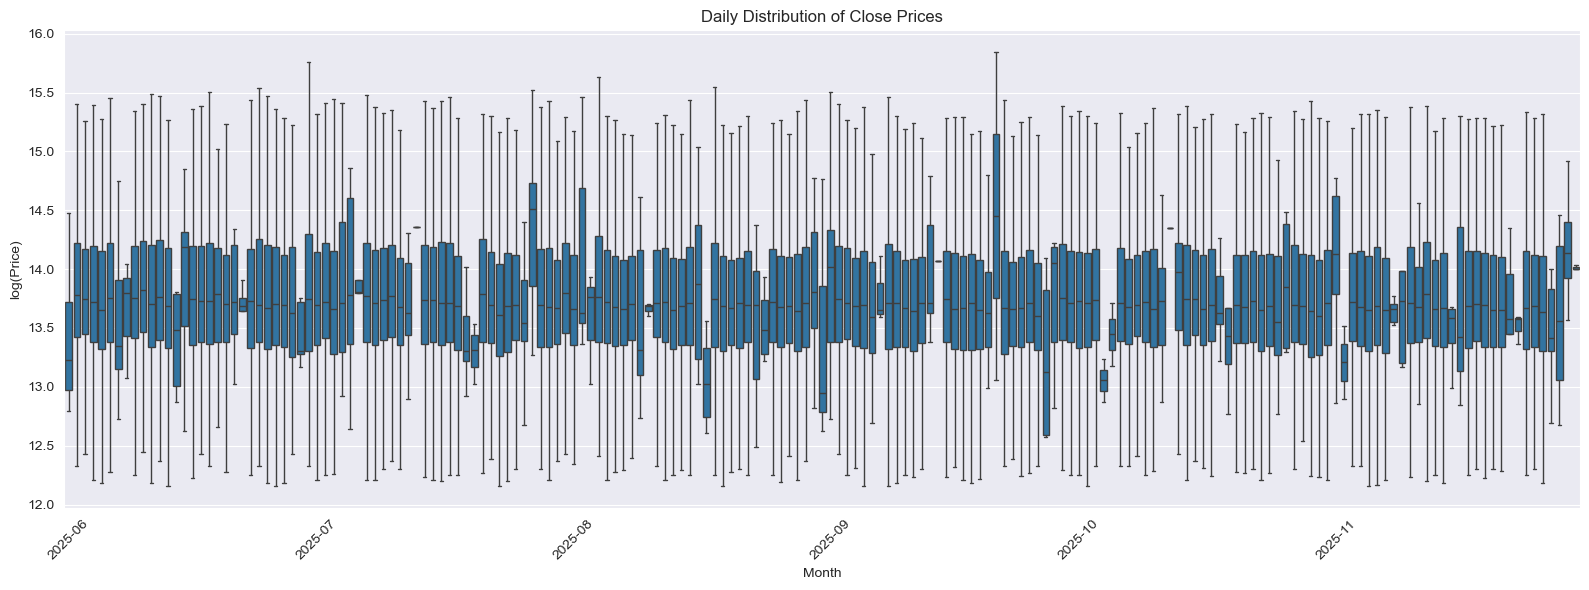

In [11]:
dist_df = pd.DataFrame()
dist_df["day_bucket"] = processed_df["CloseDate"].dt.date
dist_df["month_bucket"] = processed_df["CloseDate"].dt.to_period("M").astype(str)
dist_df["logClosePrice"] = processed_df["logClosePrice"]
dist_df["CloseDate"] = processed_df["CloseDate"]
order = sorted(dist_df["day_bucket"].unique())

fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(
    data=dist_df,
    x="day_bucket",
    y="logClosePrice",
    order=order,
    showfliers=False,
    ax=ax
)
# map day -> month
day_to_month = (
    dist_df.drop_duplicates("day_bucket")
    .set_index("day_bucket")["month_bucket"]
)

ticks = []
labels = []
last = None

for i, d in enumerate(order):
    m = day_to_month[d]
    if m != last:
        ticks.append(i)
        labels.append(m)
        last = m

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45)

ax.set_xlabel("Month")
ax.set_ylabel("log(Price)")
ax.set_title("Daily Distribution of Close Prices")
plt.tight_layout()
plt.show()


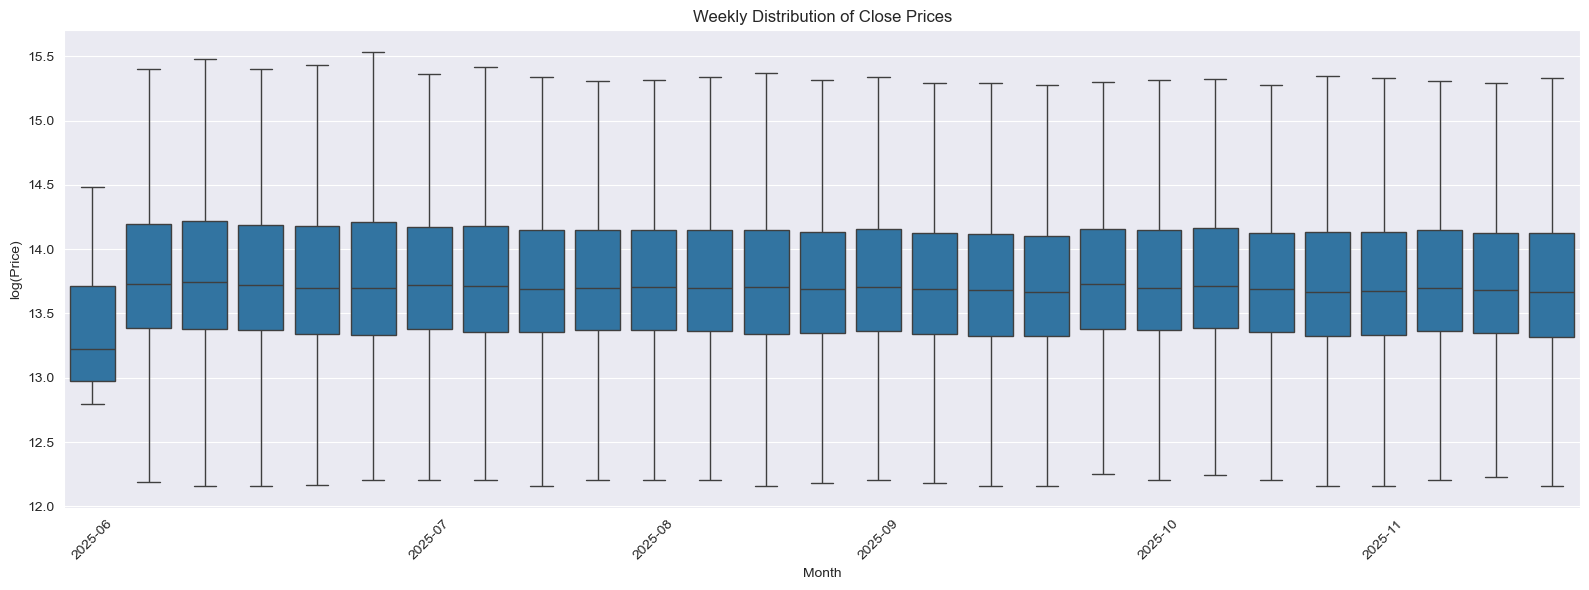

In [12]:
dist_df["week_bucket"] = dist_df["CloseDate"].dt.to_period("W").astype(str)
order = sorted(dist_df["week_bucket"].unique())

fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(
    data=dist_df,
    x="week_bucket",
    y="logClosePrice",
    order=order,
    showfliers=False,
    ax=ax
)

week_to_month = (
    dist_df.drop_duplicates("week_bucket")
    .set_index("week_bucket")["month_bucket"]
)

ticks, labels = [], []
last = None
for i, w in enumerate(order):
    m = week_to_month[w]
    if m != last:
        ticks.append(i)
        labels.append(m)
        last = m

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45)

ax.set_xlabel("Month")
ax.set_ylabel("log(Price)")
ax.set_title("Weekly Distribution of Close Prices")
plt.tight_layout()
plt.show()


## 1.3 price by location

<Axes: xlabel='logClosePrice', ylabel='CountyOrParish'>

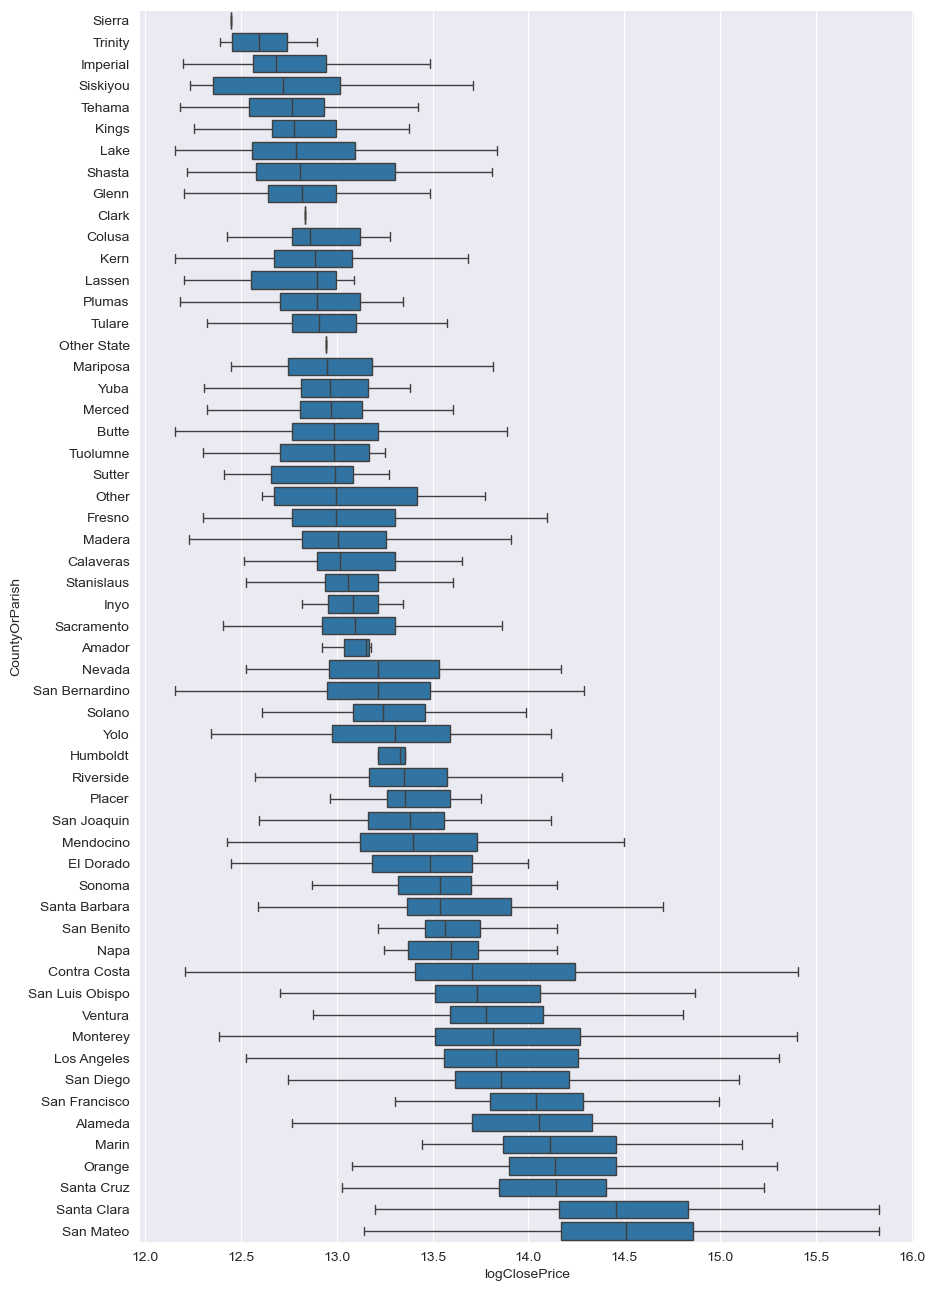

In [13]:
order = (
    processed_df.groupby("CountyOrParish")["logClosePrice"]
    .median()
    .sort_values()
    .index
)

height = 0.25 * len(processed_df["CountyOrParish"].unique())
plt.figure(figsize=(10, 16))

sns.boxplot(
    data=processed_df,
    y='CountyOrParish',
    x='logClosePrice',
    order=order,
    showfliers=False
)

## 2. Quality

In [14]:
data_quality_summary(processed_df)

,column,dtype,n_unique,missing_%,num_missing
36,BelowGradeFinishedArea,float64,42,99.29,67337
23,BuilderName,object,812,95.41,64707
43,LotSizeDimensions,object,2780,93.62,63493
31,BuildingAreaTotal,float64,2444,93.47,63389
20,ElementarySchool,object,1124,86.79,58859
38,MiddleOrJuniorSchool,object,585,86.57,58708
41,HighSchool,object,476,82.63,56038
17,AssociationFeeFrequency,object,4,75.00,50865
16,CoListOfficeName,object,2346,73.42,49793
25,SubdivisionName,object,5638,64.52,43755


## 3. Correlation

In [15]:
numeric_cols = list(processed_df.select_dtypes(include=["number"]).columns)
categorical_cols = [c for c in processed_df.columns if c not in numeric_cols]

numeric_corr = processed_df[numeric_cols].corr()
numeric_corr

,OriginalListPrice,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,ParkingTotal,LotSizeAcres,YearBuilt,...,BuildingAreaTotal,BedroomsTotal,BelowGradeFinishedArea,Stories,LotSizeArea,MainLevelBedrooms,GarageSpaces,AssociationFee,LotSizeSquareFeet,logClosePrice
OriginalListPrice,1.000000,0.098807,0.002556,-0.010480,0.060528,0.100070,0.005090,0.055374,0.000832,-0.002214,...,0.052933,0.031440,0.166653,0.021931,0.004156,-0.004792,0.005468,0.042601,0.000207,0.088905
ClosePrice,0.098807,1.000000,-0.001756,-0.079795,0.601043,0.989181,-0.011999,0.024869,0.007976,-0.016813,...,0.707016,0.346822,0.160868,0.234856,0.036358,-0.080386,0.049481,0.258956,0.004131,0.897651
Latitude,0.002556,-0.001756,1.000000,-0.542428,-0.056467,-0.019639,-0.015794,-0.037096,-0.004294,-0.072084,...,-0.003207,-0.045514,0.001578,-0.035462,0.034802,0.100163,-0.029101,0.007001,-0.004273,-0.040749
Longitude,-0.010480,-0.079795,-0.542428,1.000000,0.030060,-0.067053,0.043109,0.021024,0.004001,0.110122,...,-0.080313,0.018893,0.011205,0.001245,-0.013587,-0.031214,0.018889,-0.009794,0.003881,-0.094498
LivingArea,0.060528,0.601043,-0.056467,0.030060,1.000000,0.617150,0.127513,0.063933,0.015990,0.372144,...,1.000000,0.666639,0.264855,0.448983,0.086663,-0.125754,0.119224,0.223145,0.008363,0.569926
ListPrice,0.100070,0.989181,-0.019639,-0.067053,0.617150,1.000000,0.015852,0.027612,0.008638,0.001214,...,0.716570,0.351943,0.167949,0.235488,0.043894,-0.082072,0.052236,0.266722,0.004605,0.881293
DaysOnMarket,0.005090,-0.011999,-0.015794,0.043109,0.127513,0.015852,1.000000,0.014132,0.006736,0.130333,...,0.122348,0.033515,0.118979,0.053386,0.091728,-0.040551,0.004084,0.076768,-0.006018,-0.069675
ParkingTotal,0.055374,0.024869,-0.037096,0.021024,0.063933,0.027612,0.014132,1.000000,0.000644,0.040331,...,0.316439,0.044306,0.086071,0.013673,0.022966,0.008135,0.794044,0.007412,0.000242,0.028579
LotSizeAcres,0.000832,0.007976,-0.004294,0.004001,0.015990,0.008638,0.006736,0.000644,1.000000,0.010823,...,0.070298,0.004701,0.026804,-0.005765,0.010315,0.003327,0.002318,0.084304,1.000000,0.001625
YearBuilt,-0.002214,-0.016813,-0.072084,0.110122,0.372144,0.001214,0.130333,0.040331,0.010823,1.000000,...,0.339285,0.279691,-0.013441,0.324669,0.039802,-0.218411,0.097183,0.172368,0.002859,-0.060144


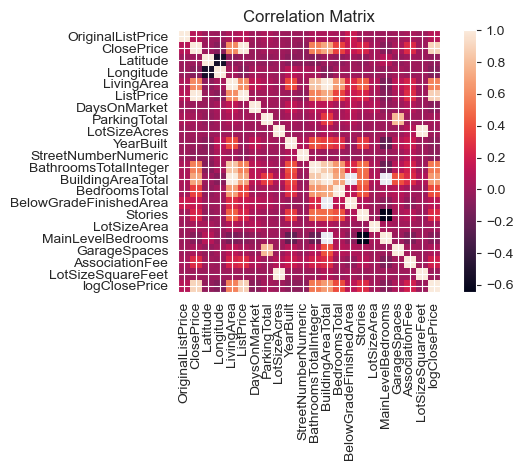

In [16]:
plt.figure()
plt.imshow(numeric_corr)
plt.colorbar()
plt.xticks(range(len(numeric_corr)), numeric_corr.columns, rotation=90)
plt.yticks(range(len(numeric_corr)), numeric_corr.columns)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [17]:
numeric_corr[["ClosePrice", "logClosePrice"]].sort_values(by="logClosePrice", key=lambda x: x.abs(), ascending=False)

,ClosePrice,logClosePrice
logClosePrice,0.897651,1.000000
ClosePrice,1.000000,0.897651
ListPrice,0.989181,0.881293
BuildingAreaTotal,0.707016,0.664032
LivingArea,0.601043,0.569926
BathroomsTotalInteger,0.557080,0.534570
BedroomsTotal,0.346822,0.382876
Stories,0.234856,0.264930
AssociationFee,0.258956,0.197732
BelowGradeFinishedArea,0.160868,0.116475


In [21]:
processed_df["Latitude"].describe(), processed_df["Longitude"].describe()

(count    67813.000000
 mean        34.750036
 std          1.714057
 min          0.000000
 25%         33.768308
 50%         34.088607
 75%         34.866974
 max         41.894714
 Name: Latitude, dtype: float64,
 count    67813.000000
 mean      -118.626909
 std          3.328032
 min       -124.193201
 25%       -119.182768
 50%       -118.041610
 75%       -117.270412
 max        120.432670
 Name: Longitude, dtype: float64)